# Denoising Autoencoder

Let's get started by importing our libraries and getting the dataset.

In [61]:
# The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [62]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False,
                                  download=True, transform=transform)

# Create training and test dataloaders
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

# how many samples are in train and test data
number_train_samples = len(train_loader.sampler)
number_test_samples = len(test_loader.sampler)
print(f"Number of training samples: {number_train_samples}")
print(f"Number of test samples: {number_test_samples}")

# reduce trainng and test data samples by half, pick at random
new_train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, sampler=torch.utils.data.SubsetRandomSampler(np.random.choice(number_train_samples, number_train_samples//2, replace=False)))
new_test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, sampler=torch.utils.data.SubsetRandomSampler(np.random.choice(number_test_samples, number_test_samples//2, replace=False)))

Number of training samples: 60000
Number of test samples: 10000


### Visualize the Data

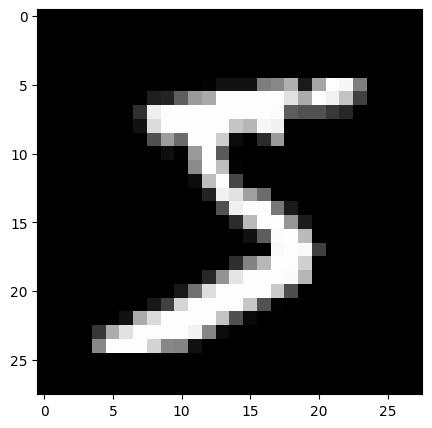

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

plt.show()


---
# Denoising


In [64]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 32), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        # conv layer (depth from 32 --> 16), 3x3 kernels
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        # conv layer (depth from 16 --> 8), 3x3 kernels
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        # transpose layer, a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)  # kernel_size=3 to get to a 7x7 image output
        # two more transpose layers with a kernel of 2
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        # one, final, normal conv layer to decrease the depth
        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # add third hidden layer
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        # transpose again, output should have a sigmoid applied
        x = F.sigmoid(self.conv_out(x))
                
        return x

# initialize the NN
model = ConvDenoiser()
print(model)

ConvDenoiser(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


---
## Training

In [65]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [66]:
# Training for one noise level

# number of epochs to train the model
n_epochs = 10

# for adding noise to images
noise_factor=0.5

for epoch in range(1, n_epochs+1):
    # print statement that shows the epoch
    print(f'epoch: {epoch}')
    
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in new_train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        
        ## add random noise to the input images
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
                
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs)
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

epoch: 1
Epoch: 1 	Training Loss: 0.542419
epoch: 2
Epoch: 2 	Training Loss: 0.328497
epoch: 3
Epoch: 3 	Training Loss: 0.289720
epoch: 4
Epoch: 4 	Training Loss: 0.270261
epoch: 5
Epoch: 5 	Training Loss: 0.257391
epoch: 6
Epoch: 6 	Training Loss: 0.248526
epoch: 7
Epoch: 7 	Training Loss: 0.242089
epoch: 8
Epoch: 8 	Training Loss: 0.236206
epoch: 9
Epoch: 9 	Training Loss: 0.231305
epoch: 10
Epoch: 10 	Training Loss: 0.228528


In [57]:
# Training for multiple noise levels

# number of epochs to train the model
n_epochs = 10

# for adding noise to images
noise_factor_1=0.45
noise_factor_2=0.5

for epoch in range(1, n_epochs+1):
    # print statement that shows the epoch
    print(f'epoch: {epoch}')
    
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in new_train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        
        ## add random noise to the input images
        noisy_imgs = images + noise_factor_1 * torch.randn(*images.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        ## add random noise to the input images
        noisy_imgs2 = images + noise_factor_2 * torch.randn(*images.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs2 = np.clip(noisy_imgs, 0., 1.)
                
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs2)
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, noisy_imgs)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

epoch: 1
Epoch: 1 	Training Loss: 0.720994
epoch: 2
Epoch: 2 	Training Loss: 0.720533
epoch: 3
Epoch: 3 	Training Loss: 0.720696
epoch: 4
Epoch: 4 	Training Loss: 0.719586
epoch: 5
Epoch: 5 	Training Loss: 0.718916
epoch: 6
Epoch: 6 	Training Loss: 0.718408
epoch: 7
Epoch: 7 	Training Loss: 0.717805
epoch: 8
Epoch: 8 	Training Loss: 0.717672
epoch: 9
Epoch: 9 	Training Loss: 0.717713
epoch: 10
Epoch: 10 	Training Loss: 0.717141


In [71]:
# extract weight and bias matrices from trained network
# Get the state dictionary of the model
model_state_dict = model.state_dict()

# Extract the weight and bias matrices from the state dictionary
conv1_weight = model_state_dict['conv1.weight']
conv1_bias = model_state_dict['conv1.bias']

conv2_weight = model_state_dict['conv2.weight']
conv2_bias = model_state_dict['conv2.bias']

conv3_weight = model_state_dict['conv3.weight']
conv3_bias = model_state_dict['conv3.bias']

t_conv1_weight = model_state_dict['t_conv1.weight']
t_conv1_bias = model_state_dict['t_conv1.bias']

t_conv2_weight = model_state_dict['t_conv2.weight']
t_conv2_bias = model_state_dict['t_conv2.bias']

t_conv3_weight = model_state_dict['t_conv3.weight']
t_conv3_bias = model_state_dict['t_conv3.bias']

conv_out_weight = model_state_dict['conv_out.weight']
conv_out_bias = model_state_dict['conv_out.bias']


In [72]:
from scipy.io import savemat

path = 'Params/'

# Save the weights and biases as .mat files
savemat(path + 'conv1_weight.mat', {'conv1_weight': conv1_weight.numpy()})
savemat(path + 'conv1_bias.mat', {'conv1_bias': conv1_bias.numpy()})

savemat(path + 'conv2_weight.mat', {'conv2_weight': conv2_weight.numpy()})
savemat(path + 'conv2_bias.mat', {'conv2_bias': conv2_bias.numpy()})

savemat(path + 'conv3_weight.mat', {'conv3_weight': conv3_weight.numpy()})
savemat(path + 'conv3_bias.mat', {'conv3_bias': conv3_bias.numpy()})

savemat(path + 't_conv1_weight.mat', {'t_conv1_weight': t_conv1_weight.numpy()})
savemat(path + 't_conv1_bias.mat', {'t_conv1_bias': t_conv1_bias.numpy()})

savemat(path + 't_conv2_weight.mat', {'t_conv2_weight': t_conv2_weight.numpy()})
savemat(path + 't_conv2_bias.mat', {'t_conv2_bias': t_conv2_bias.numpy()})

savemat(path + 't_conv3_weight.mat', {'t_conv3_weight': t_conv3_weight.numpy()})
savemat(path + 't_conv3_bias.mat', {'t_conv3_bias': t_conv3_bias.numpy()})

savemat(path + 'conv_out_weight.mat', {'conv_out_weight': conv_out_weight.numpy()})
savemat(path + 'conv_out_bias.mat', {'conv_out_bias': conv_out_bias.numpy()})


## Checking out the results

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprising great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

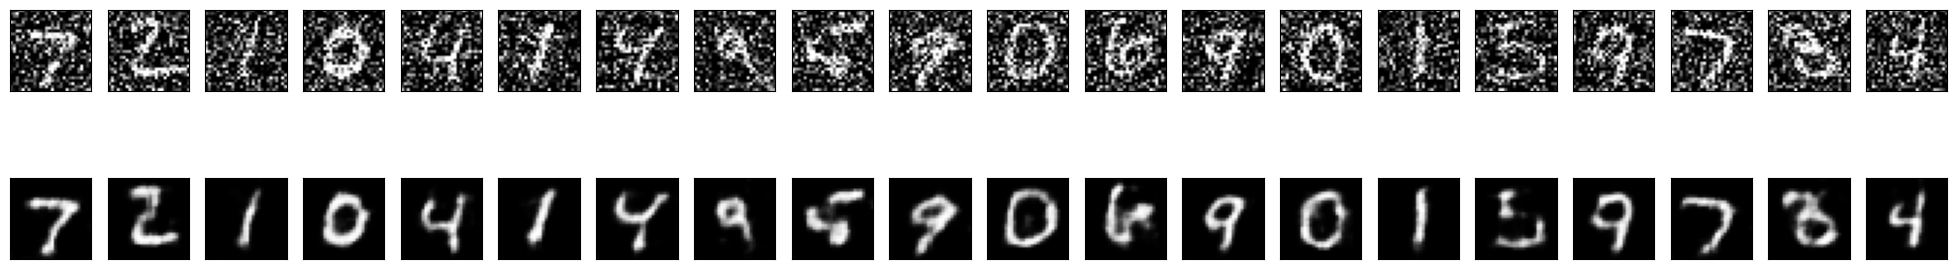

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
output = model(noisy_imgs)
# prep images for display
noisy_imgs = noisy_imgs.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=batch_size, sharex=True, sharey=True, figsize=(25,4))

# input images on the top row, reconstructions on the bottom
for i in range(batch_size):
    axes[0, i].imshow(np.squeeze(noisy_imgs[i]), cmap='gray')
    axes[0, i].get_xaxis().set_visible(False)
    axes[0, i].get_yaxis().set_visible(False)
    
    axes[1, i].imshow(np.squeeze(output[i]), cmap='gray')
    axes[1, i].get_xaxis().set_visible(False)
    axes[1, i].get_yaxis().set_visible(False)

plt.show()

